1. Read the sections“Introducing the Julia Set”and “Calculating the Full Julia Set”on Chapter  2.  Profiling  to  Find  Bottlenecksfrom  the book: M.  Gorelick  &  I.  Ozsvald (2020). High Performance Python. Practical Performant Programming for Humans.Second  Edition.  United  States  of  America:  O’Reilly  Media,  Inc.Implement  the chapter functions(Example2-1, 2-2, 2-3 and 2-4)on Python in order to calculate the Julia Set. Make the representation for the false gray and pure gray scale.

In [18]:
import time
import array
from PIL import Image

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193


def show_greyscale(output_raw, width, height, max_iterations):
    """Convert list to array, show using PIL"""
    # convert our output to PIL-compatible input
    # scale to [0...255]
    max_iterations = float(max(output_raw))
    print(max_iterations)
    scale_factor = float(max_iterations)
    scaled = [int(o / scale_factor * 255) for o in output_raw]
    output = array.array('B', scaled)  # array of unsigned ints
    # display with PIL
    im = Image.new("L", (width, width))
    # EXPLAIN RAW L 0 -1
    im.frombytes(output.tobytes(), "raw", "L", 0, -1)
    im.show()


def show_false_greyscale(output_raw, width, height, max_iterations):
    """Convert list to array, show using PIL"""
    # convert our output to PIL-compatible input
    assert width * height == len(output_raw)  # sanity check our 1D array and desired 2D form
    # rescale output_raw to be in the inclusive range [0..255]
    max_value = float(max(output_raw))
    output_raw_limited = [int(float(o) / max_value * 255) for o in output_raw]
    # create a slightly fancy colour map that shows colour changes with
    # increased contrast (thanks to John Montgomery)
    output_rgb = ((o + (256 * o) + (256 ** 2) * o) * 16 for o in output_raw_limited)  # fancier
    output_rgb = array.array('I', output_rgb)  # array of unsigned ints (size is platform specific)
    # display with PIL/pillow
    im = Image.new("RGB", (width, height))
    # EXPLAIN RGBX L 0 -1
    im.frombytes(output_rgb.tobytes(), "raw", "RGBX", 0, -1)
    im.show()


def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output


def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex co-ordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # set width and height to the generated pixel counts, rather than the
    # pre-rounding desired width and height
    width = len(x)
    height = len(y)
    # build a list of co-ordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # this sum is expected for 1000^2 grid with 300 iterations

    if draw_output:
        #show_false_greyscale(output, width, height, max_iterations)
        show_greyscale(output, width, height, max_iterations)


if __name__ == "__main__":
    # Calculate the Julia set using a pure Python solution with
    # reasonable defaults for a laptop
    # set draw_output to True to use PIL to draw an image
    calc_pure_python(draw_output=True, desired_width=1000, max_iterations=300)


Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 7.155222654342651 seconds
300.0


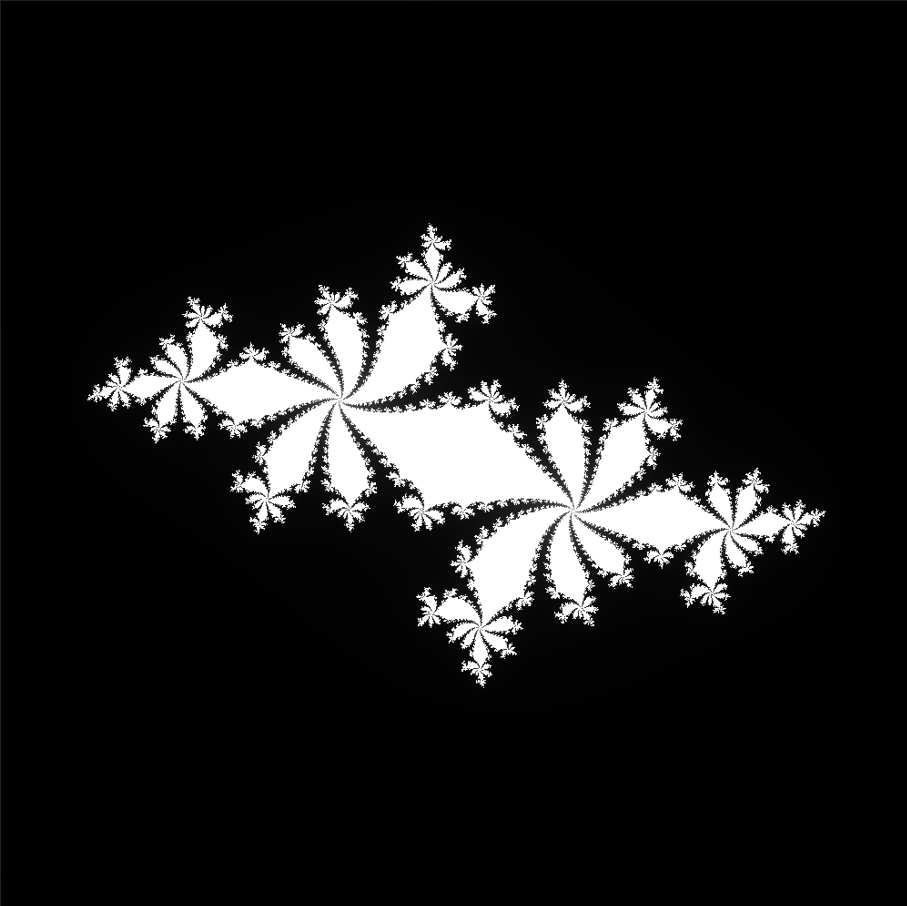

## Figure 2-2. Two coordinate examples evolving for the Julia set

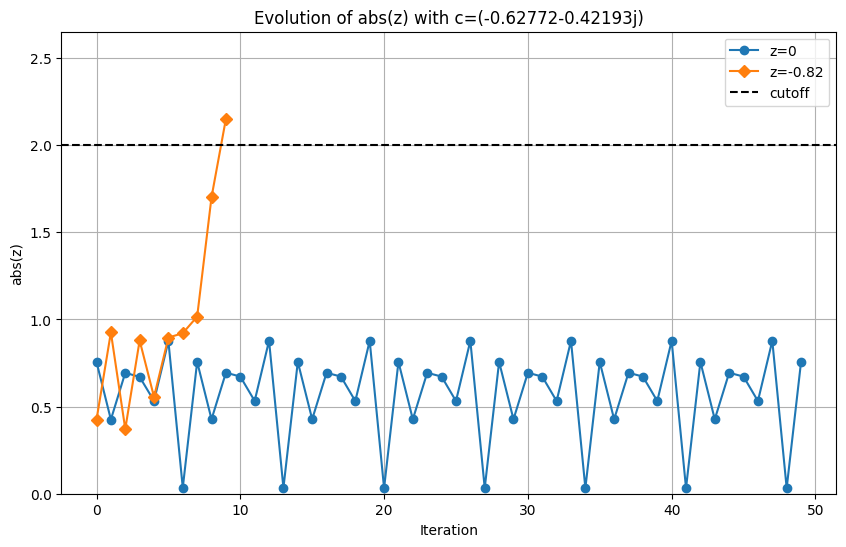

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_julia_iterations(c, z_values, maxiter):
    plt.figure(figsize=(10, 6))

    # Iterate over each initial z value
    for z_init in z_values:
        z = z_init
        abs_values = []
        for i in range(maxiter):
            z = z**2 + c
            abs_values.append(abs(z))
            if abs(z) > 2:
                break

        # Plot the absolute values
        plt.plot(abs_values, label=f'z={z_init}', marker='o' if z_init == 0 else 'D')

    plt.axhline(y=2, color='k', linestyle='--', label='cutoff')
    plt.title('Evolution of abs(z) with c={}'.format(c))
    plt.xlabel('Iteration')
    plt.ylabel('abs(z)')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, max(abs_values) + 0.5)  # adjust the y-axis limit to show all points clearly
    plt.show()

# Constants
c = complex(-0.62772, -0.42193)
maxiter = 50
z_values = [0, -0.82]

# Generate the plot
plot_julia_iterations(c, z_values, maxiter)

2. Define a new function, timefn, which takes a function as an argument: the inner function, measure_time, takes *args (a variable number of positional arguments) and **kwargs (a variable number of key/value arguments) and passes them through to fn for execution. Decorate calculate_z_serial_purepythonwith @timefn to profile it. Implement Example 2-5 and adapt your current source code.

In [20]:
import time
from functools import wraps

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print(f"@timefn: {fn.__name__} took {t2 - t1} seconds")
        return result
    return measure_time

@timefn
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y2 - y1) / desired_width
    x = [x1 + i * x_step for i in range(desired_width)]
    y = [y1 + i * y_step for i in range(desired_width)]
    zs = [complex(x[i % desired_width], y[i // desired_width]) for i in range(desired_width ** 2)]
    cs = [complex(c_real, c_imag) for i in range(desired_width ** 2)]

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    # Verify the result is as expected
    assert sum(output) == 33219980  # this sum is expected for a 1000^2 grid with 300 iterations

# Run the Julia set calculation with the corrected function
calc_pure_python(draw_output=True, desired_width=1000, max_iterations=300)

Length of x: 1000
Total elements: 1000000
@timefn: calculate_z_serial_purepython took 7.094485282897949 seconds
calculate_z_serial_purepython took 7.094485282897949 seconds


3. Use the timeit modeule to get a coarse measurement of the execution speed of the CPU-bound  function. Runs  10  loops  with  5  repetitions.  Show  how  to do  the measurement on the command lineand on a Jupyter Notebook.


Jupyter Notebook:

In [21]:
import time

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

# Initialize the lists of complex coordinates (zs) and complex parameters (cs) for Julia set calculation
desired_width = 1000
max_iterations = 300
x_step = (x2 - x1) / desired_width
y_step = (y2 - y1) / desired_width
x = [x1 + i * x_step for i in range(desired_width)]
y = [y1 + i * y_step for i in range(desired_width)]
zs = [complex(x[i % desired_width], y[i // desired_width]) for i in range(desired_width ** 2)]
cs = [complex(c_real, c_imag) for i in range(desired_width ** 2)]

# Now you can use %timeit on calculate_z_serial_purepython
%timeit calculate_z_serial_purepython(max_iterations, zs, cs)


6.73 s ± 286 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


4. Use the cProfile module to profile the source code (.py). Sort the results by the time
spent inside each function. This will give a view into the slowest parts. Analyze the
output and make a syntesis of the findings. Show how to use the cProfile module on
the command line and on a Jupyter Notebook

In [22]:
import cProfile
import time

# Attempt to import the profile decorator from line_profiler if installed
try:
    from line_profiler import profile
except ImportError:
    def profile(func):
        """ Dummy decorator in case line_profiler is not installed. """
        return func

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

@profile
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

@profile
def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y2 - y1) / desired_width
    x = [x1 + i * x_step for i in range(desired_width)]
    y = [y1 + i * y_step for i in range(desired_width)]
    zs = [complex(x[i % desired_width], y[i // desired_width]) for i in range(desired_width ** 2)]
    cs = [complex(c_real, c_imag) for i in range(desired_width ** 2)]

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # this sum is expected for a 1000^2 grid with 300 iterations

if __name__ == "__main__":
    cProfile.run('calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)', 'profile_stats')


Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 18.849721908569336 seconds


In [23]:
import pstats

p = pstats.Stats('profile_stats')
p.sort_stats('cumulative').print_stats(10)  # Adjust this number to display more or fewer lines

Fri Apr 12 21:20:56 2024    profile_stats

         34220170 function calls in 19.456 seconds

   Ordered by: cumulative time
   List reduced from 33 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   19.456   19.456 {built-in method builtins.exec}
        1    0.021    0.021   19.456   19.456 <string>:1(<module>)
        1    0.000    0.000   19.435   19.435 C:\Users\drako\AppData\Local\Temp\ipykernel_9948\2613920211.py:30(calc_pure_python)
        1   13.608   13.608   18.848   18.848 C:\Users\drako\AppData\Local\Temp\ipykernel_9948\2613920211.py:16(calculate_z_serial_purepython)
 34219980    5.240    0.000    5.240    0.000 {built-in method builtins.abs}
        1    0.335    0.335    0.335    0.335 C:\Users\drako\AppData\Local\Temp\ipykernel_9948\2613920211.py:37(<listcomp>)
        1    0.246    0.246    0.246    0.246 C:\Users\drako\AppData\Local\Temp\ipykernel_9948\2613920211.py:38(<listcomp>)
    

5. Use snakeviz to get a high-level understanding of the cPrifile statistics file. Analyze
the output and make a syntesis of the findings.

In [24]:
!pip install snakeviz

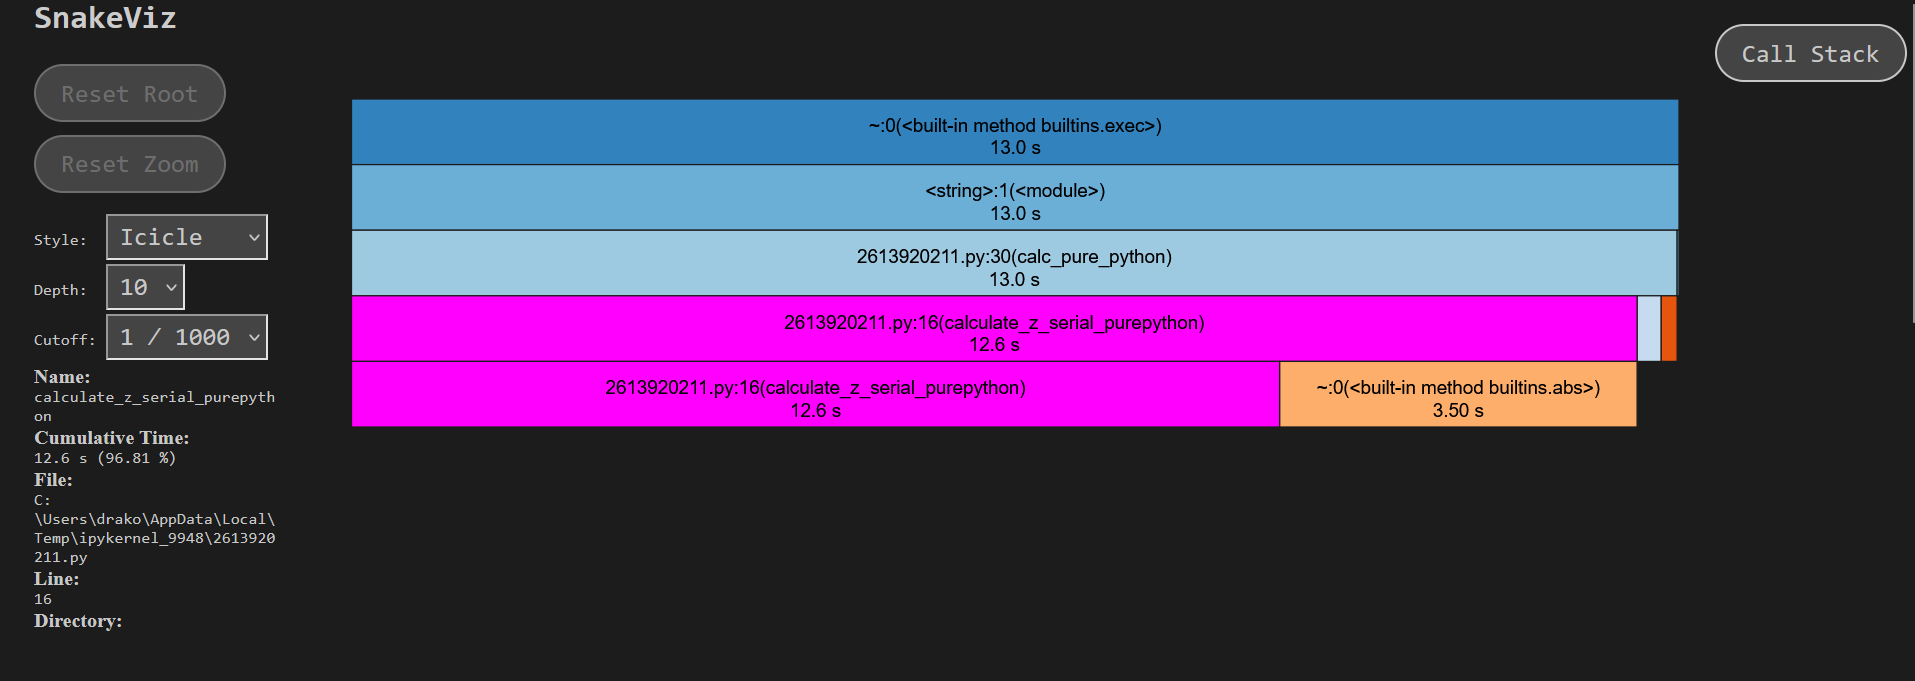

In [25]:
if __name__ == "__main__":
    cProfile.run('calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)', 'profile_stats')

Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 18.519707441329956 seconds


In [16]:
!snakeviz profile_stats

^C


6. Use the line_profiler and kernprof file to profile line-by-line the function
calculate_z_serial_purepython. Analyze the output and make a syntesis of the
findings.

In [26]:
%pip install line_profiler

Note: you may need to restart the kernel to use updated packages.


In [27]:
%load_ext line_profiler

In [28]:
import time

# Attempt to import the profile decorator from line_profiler if installed
try:
    from line_profiler import profile
except ImportError:
    def profile(func):
        """ Dummy decorator in case line_profiler is not installed. """
        return func

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

@profile
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

@profile
def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y2 - y1) / desired_width
    x = [x1 + i * x_step for i in range(desired_width)]
    y = [y1 + i * y_step for i in range(desired_width)]
    zs = [complex(x[i % desired_width], y[i // desired_width]) for i in range(desired_width ** 2)]
    cs = [complex(c_real, c_imag) for i in range(desired_width ** 2)]

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # this sum is expected for a 1000^2 grid with 300 iterations

# Calculate the Julia set using a pure Python solution with
# reasonable defaults for a laptop
calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)


Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 6.530691385269165 seconds


In [29]:
%lprun -f calculate_z_serial_purepython calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)

Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 159.1882882118225 seconds


Timer unit: 1e-07 s

Total time: 103.526 s
File: C:\Users\drako\AppData\Local\Temp\ipykernel_9948\2939688537.py
Function: calculate_z_serial_purepython at line 15

Line #      Hits         Time  Per Hit   % Time  Line Contents
    15                                           @profile
    16                                           def calculate_z_serial_purepython(maxiter, zs, cs):
    17                                               """Calculate output list using Julia update rule"""
    18         1      45793.0  45793.0      0.0      output = [0] * len(zs)
    19   1000001    7774367.0      7.8      0.8      for i in range(len(zs)):
    20   1000000    6343371.0      6.3      0.6          n = 0
    21   1000000    7794439.0      7.8      0.8          z = zs[i]
    22   1000000    6983442.0      7.0      0.7          c = cs[i]
    23  34219980  461343866.0     13.5     44.6          while abs(z) < 2 and n < maxiter:
    24  33219980  294939019.0      8.9     28.5              z = z 

7. Use the memory_profiler to diagnose memory usage. Analyze the output and make
a syntesis of the findings.

In [30]:
%pip install memory_profiler
%pip install psutil

%load_ext memory_profiler



Note: you may need to restart the kernel to use updated packages.


In [31]:
import time

# Attempt to import the profile decorator from memory_profiler if installed
try:
    from memory_profiler import profile
except ImportError:
    def profile(func):
        """Dummy decorator in case memory_profiler is not installed."""
        return func

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

@profile
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

@profile
def calc_pure_python(draw_output, desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs), build Julia set and display"""
    x_step = (x2 - x1) / desired_width
    y_step = (y2 - y1) / desired_width
    x = [x1 + i * x_step for i in range(desired_width)]
    y = [y1 + i * y_step for i in range(desired_width)]
    zs = [complex(x[i % desired_width], y[i // desired_width]) for i in range(desired_width ** 2)]
    cs = [complex(c_real, c_imag) for i in range(desired_width ** 2)]

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    assert sum(output) == 33219980  # this sum is expected for a 1000^2 grid with 300 iterations

# Calculate the Julia set using a pure Python solution with
# reasonable defaults for a laptop
calc_pure_python(draw_output=False, desired_width=1000, max_iterations=300)



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "C:\Users\drako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\memory_profiler.py", line 847, in enable
    sys.settrace(self.trace_memory_usage)



ERROR: Could not find file C:\Users\drako\AppData\Local\Temp\ipykernel_9948\4276889128.py
Length of x: 1000
Total elements: 1000000
ERROR: Could not find file C:\Users\drako\AppData\Local\Temp\ipykernel_9948\4276889128.py



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "C:\Users\drako\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\memory_profiler.py", line 850, in disable
    sys.settrace(self._original_trace_function)



calculate_z_serial_purepython took 107.16407704353333 seconds


In [32]:
!mprof run julia_set_memory_profiling.py

mprof: Sampling memory every 0.1s
running new process
running as a Python program...
Length of x: 1000
Total elements: 1000000
Filename: julia_set_memory_profiling.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    15    127.3 MiB    127.3 MiB           1   @profile
    16                                         def calculate_z_serial_purepython(maxiter, zs, cs):
    17                                             """Calculate output list using Julia update rule"""
    18    134.9 MiB      7.6 MiB           1       output = [0] * len(zs)
    19    137.9 MiB -14364.9 MiB     1000001       for i in range(len(zs)):
    20    137.9 MiB -14364.9 MiB     1000000           n = 0
    21    137.9 MiB -14364.9 MiB     1000000           z = zs[i]
    22    137.9 MiB -14364.9 MiB     1000000           c = cs[i]
    23    137.9 MiB -103815.4 MiB    34219980           while abs(z) < 2 and n < maxiter:
    24    137.9 MiB -89453.5 MiB    33219980               z = z * z + c
    25  